### Project 5 - Vehicle Detection and Tracking

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


Generally:
- A labeled dataset is provided
- Decide what features to extract
- Train a classifier 
- Use sliding window to search for vehicle
- Develop detection and tracking scheme in video stream - remove duplicate and reject false positive


Specifically:
- extracted HOG features from the training images
- Tune and find HOG parameters
- trained a classifier using your selected HOG features 
- implemented a sliding window search (decide what scales to search and how much to overlap windows)
- optimize the performance of your classifier

Steps:
<br> 1. started by reading in all the vehicle and non-vehicle images
<br> 2. explored different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and 
 cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for 
 what the skimage.hog() output looks like
<br> 3. settled on your final choice of HOG parameters
<br> 4. trained a classifier using your selected HOG features (and color features if you used them)
<br> 5. implemented a sliding window search
<br> 6. implemented some kind of filter for false positives and some method for combining overlapping bounding boxes

#### Version Note

Revision C: Modified for video pipeline ; removed many testing code ; remove boot-force method and use tracking to improve run time ; use 1 channel for HOG ; use LUV color space ; false positive reduced by conditioning for video

Note: 
- cv2.imread() - 0 to 255 for png
- matplotlib image - 0 to 1 for png
- matplotlib image - 0 to 255 for jpg

- data sets are quite balanced

In [88]:
# Imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split          # for scikit-learn >= 0.18
from scipy.ndimage.measurements import label                  # for heatmap implementation
import sklearn
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.0.


In [89]:
# Part I - Feature Extraction
# Function Definition

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []                                                   # Create a list to append feature vectors to    
    for file in imgs:                                               # Iterate through the list of images Cars/nonCars
        file_features = []
        image = cv2.imread(file)                                    # Read in each one by one; change from mpimg  
        
        if color_space != 'RGB':                                    # apply color conversion if other than 'RGB'
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)  
            
        if spatial_feat == True:                                               # Extract spatial feature
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:                                                  # Extract color histogram feature
            hist_features = color_hist(feature_image, nbins=hist_bins)                   
            file_features.append(hist_features)
            
        if hog_feat == True:                                                   # Extract HOG feature   
            if hog_channel == 'ALL':                                   
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_HSV2RGB)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_HLS2RGB)
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
                hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)                       
            file_features.append(hog_features)                  # Append the new feature vector to the features list
        
        features.append(np.concatenate(file_features))                          # Concatenate all features
    
    return features 


# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 


# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:                                                                             # visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:                                                                                 # Otherwise return one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [90]:
# Part I - Feature Extraction
# Import car and non-car images

# Read in car images from various files - Better control of image selection input
Carimages_GTI_Far = glob.glob('./vehicles/GTI_Far/*.png')
Carimages_GTI_Left = glob.glob('./vehicles/GTI_Left/*.png')
Carimages_GTI_Right = glob.glob('./vehicles/GTI_Right/*.png')
Carimages_GTI_MiddleClose = glob.glob('./vehicles/GTI_MiddleClose/*.png')
Carimages_KITTI_extracted = glob.glob('./vehicles/KITTI_extracted/*.png')

print ("Number of Images from 'Cars' input:")
print ("Carimages_GTI_Far - " + str(len(Carimages_GTI_Far)))
print ("Carimages_GTI_Far - " + str(len(Carimages_GTI_Left)))
print ("Carimages_GTI_Far - " + str(len(Carimages_GTI_Right)))
print ("Carimages_GTI_Far - " + str(len(Carimages_GTI_MiddleClose)))
print ("Carimages_GTI_Far - " + str(len(Carimages_KITTI_extracted)))
print("Total number of Cars - " + str((len(Carimages_GTI_Far))+(len(Carimages_GTI_Left))+(len(Carimages_GTI_Right))+
                                  (len(Carimages_GTI_MiddleClose))+(len(Carimages_KITTI_extracted))))

# Read in non-car images from various files
notCarimages_GTI = glob.glob('./non-vehicles/GTI/image*.png')
notCarimages_GTI_Extra = glob.glob('./non-vehicles/Extras/extra*.png')
print('')
print ("Number of Images from 'notCars' input:")
print ("notCarimages_GTI - " + str(len(notCarimages_GTI)))
print ("notCarimages_GTI_Extra - " + str(len(notCarimages_GTI_Extra)))
print("Total number of notCars - " + str(((len(notCarimages_GTI))+(len(notCarimages_GTI_Extra)))))

cars = []                            # List to hold 'cars' images
notcars = []                         # List to hold 'not cars' images

# Create 'cars' array
for image in Carimages_GTI_Far:
    cars.append(image)
for image in Carimages_GTI_Left:
    cars.append(image)
for image in Carimages_GTI_Right:
    cars.append(image)
for image in Carimages_GTI_MiddleClose:
    cars.append(image)
for image in Carimages_KITTI_extracted:
    cars.append(image)

# Create 'notcars' array
for image in notCarimages_GTI:
    notcars.append(image)
for image in notCarimages_GTI_Extra:
    notcars.append(image) 


Number of Images from 'Cars' input:
Carimages_GTI_Far - 834
Carimages_GTI_Far - 909
Carimages_GTI_Far - 664
Carimages_GTI_Far - 419
Carimages_GTI_Far - 5966
Total number of Cars - 8792

Number of Images from 'notCars' input:
notCarimages_GTI - 3900
notCarimages_GTI_Extra - 5068
Total number of notCars - 8968


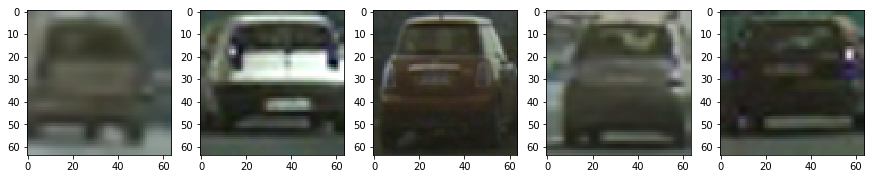

In [117]:
# Visualization of sample input data

def toGray(carsnotcars):
    img = cv2.imread(carsnotcars)
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return feature_image

def visualInput(carsnotcars):
    return cv2.imread(carsnotcars)

def visualHOG(img):
    grayImg = toGray(img)
    hog_features, hogImg = get_hog_features(grayImg[:,:], 8, 8, 2, vis=True, feature_vec=True)
    return hogImg

# Input image
plt.figure(figsize=(15,15))
plt.subplot(151)
plt.imshow(visualInput(cars[0]))
plt.subplot(152)
plt.imshow(visualInput(cars[10]))
plt.subplot(153)
plt.imshow(visualInput(cars[20]))
plt.subplot(154)
plt.imshow(visualInput(cars[30]))
plt.subplot(155)
plt.imshow(visualInput(cars[40]))


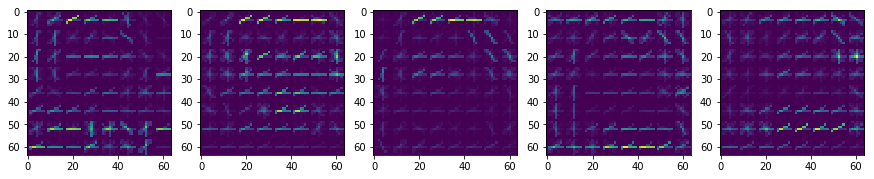

In [119]:
# Visualization of HOG data
plt.figure(figsize=(15,15))
plt.subplot(151)
plt.imshow(visualHOG(cars[0]))
plt.subplot(152)
plt.imshow(visualHOG(cars[10]))
plt.subplot(153)
plt.imshow(visualHOG(cars[20]))
plt.subplot(154)
plt.imshow(visualHOG(cars[30]))
plt.subplot(155)
plt.imshow(visualHOG(cars[40]))

In [91]:
# Part I - Feature Extraction
# Feature extraction

# Parameters for feature extraction
color_space = 'LUV'                                              # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8                                                       # HOG orientations
pix_per_cell = 8                                                 # HOG pixels per cell
cell_per_block = 2                                               # HOG cells per block
hog_channel = 0                                                  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)                                          # Spatial binning dimensions - reduce image to # x #
hist_bins = 32                                                   # Number of histogram bins
spatial_feat = True                                              # Spatial features on or off
hist_feat = True                                                 # Histogram features on or off
hog_feat = True                                                  # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)     # Put data in the right format for normalization                      
X_scaler = StandardScaler().fit(X)                                    # Set scale to normalize the feature vector
scaled_X = X_scaler.transform(X)                                      # Apply the scaler to X


In [92]:
# Part II - Train a classifier

# Define a labels vector, shuffle and split the data into training and testing sets - Chpt 28
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))              # Define the labels vector

rand_state = np.random.randint(0, 100)                          # Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Train a svm classifier
svc = LinearSVC()                                                # Use a linear SVC (support vector classifier)
t=time.time()
svc.fit(X_train, y_train)                                        # Train the SVC
t2 = time.time()
print('Test Accuracy of SVC = {0:.2f}%'.format((svc.score(X_test, y_test))*100))
print(round(t2-t, 2), 'Seconds to train SVC...')


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
Test Accuracy of SVC = 98.70%
7.81 Seconds to train SVC...


In [93]:
# Part III - Detect and Track Vehicles
# Set Global variables

thresholdNum = 5                                           # Global variable - minimum number required to be registered
smooth = 0.75                                              # Filter parameter, weight of the previous measurements

track_list = []                                            # Global variable - list of cars being tracked
bwtCars = 32                                               # Global variable - threshold of distance between label fnt identified cars
minY = 400                                                # Global variable - minimum value for y for tracking

heatLast = np.zeros((720, 1280))                           # Global variable - last heat image
boxesLast= []                                              # Global variable - last car boxes
includFrame = True                                         # Global variable - toggle image frame to read


In [94]:
# Part III - Detect and Track Vehicles
# Function Definitions - Chpt 34

# Define a single function that can extract features using hog sub-sampling and make predictions - Chpt 35
# Can be multi-scaled to run different sizes search windows
def find_cars(img, ystart, ystop, xstart, xstop, scale, step):
    boxes = []
    draw_img = np.zeros_like(img)
    img_tosearch = img[ystart:ystop,xstart:xstop,:]                          # define subsample of image to search
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')            # convert image to target color space for search
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale) + xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left, ytop_draw+ystart)
                bottom_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                boxes.append((top_left,bottom_right))
    return boxes

    
# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    imcopy = np.copy(img) 
    for bbox in bboxes:                                                      # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


# Function to convert color called by find_car()
def convert_color(img, conv='RGB2HSV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)        # for matplotlib read
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)        # for cv2 read
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


def draw_labeled_bboxes(labels):
    global track_list
    track_list_l = []
    
    for car_number in range(1, labels[1]+1):
        
        nonzero = (labels[0] == car_number).nonzero()                  # Find pixels with each car_number label value
        nonzeroy = np.array(nonzero[0])                                # Identify x and y values of those pixels
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))        # Define a bounding box based on min/max x and y
        
        size_x = (bbox[1][0] - bbox[0][0]) / 2.0            # window centroid
        size_y = (bbox[1][1] - bbox[0][1]) / 2.0
        asp = size_x / size_y                               # natural window aspect ratio
        
        x = size_x + bbox[0][0]                             # effective location of box centroid
        y = size_y + bbox[0][1]                             
        
        size_ya = int(np.sqrt(size_x * size_y / asp))
        size_xa = int(size_ya * asp)                        # Use label fnt identified aspect ratio
        
        track_list_l.append(np.array([x, y, size_xa, size_ya]))
        
        if len(track_list) > 0:
            track_l = track_list_l[-1]                      # track list last entry
            dist = []
            
            for track in track_list:
                dist.append(distance(track, track_l))
            min_d = min(dist)
            
            if min_d < bwtCars:
                ind = dist.index(min_d)
                track_list_l[-1] = track_list[ind] * smooth + (1.0 - smooth) * track_list_l[-1]
    
    track_list = track_list_l
    boxes = []
    for track in track_list_l:
        boxes.append(trackboxes(track))
    return boxes


def draw_labeled_bboxes_single(img, labels):    
    for car_number in range(1, labels[1]+1):                            # Iterate through all detected cars        
        nonzero = (labels[0] == car_number).nonzero()                   # Find pixels with each car_number label value        
        nonzeroy = np.array(nonzero[0])                                 # Identify x and y values of those pixels
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))        
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)              # Draw the box on the image
    return img                                                          # Return the image


def processFrame(img):
    global heatLast, boxesLast, includFrame, thresholdNum
    if (includFrame):                                            # Skip every other video frame to improve speed and stability
        heat = np.zeros_like(img[:,:,0]).astype(np.float)        # Create base heat map image - all black initially 
        boxes = []                                               # List of windows to store found car boxes
        
        # Search for cars in different regions of the image as vehichle enter into the view
        boxes = find_cars(img, 400, 460, 300, 1000, 0.8, 3)            # forward vehicle approach 
        boxes += find_cars(img, 400, 680, 950, 1280, 2.0, 2)           # RHS vehicle entering - big car scale 2.0 
        boxes += find_cars(img, 400, 680, 950, 1280, 1.5, 2)           # RHS vehicle entering - smaller car scale 1.5
        
        # Refined searching by tracking cars
        for track in track_list:                                       # for each identified individual object
            y_loc = track[1] + track[3]                                # y value window corners
            searchWidth = (y_loc * 2.841 - 1170.0) / 3.0                 # literature provided values based on lane dim
            if searchWidth < 100:
                searchWidth = 100
            searchHeight = searchWidth / 1.2                            
            searchWidth = max(searchWidth, track[2])
            xs = int(track[0] - searchWidth)                            # starting position for x; define search width
            xf = int(track[0] + searchWidth)                            # end position for x
            
            if track[1] < minY:                                         # if lower y of box is lower than threshold y
                track[1] = minY 
                
            ys = int(track[1] - searchHeight)
            yf = int(track[1] + searchHeight)

            if ys < minY - 40: 
                ys = minY - 40                                  # Reduce false-positive by eliminating impossible areas
            if yf > 720: 
                yf = 720   
                     
            # Apply multi scale image windows
            scale = 0.8                                                 # starting scaling factor from experiment  
            boxes+=find_cars(img, ys, yf, xs, xf, scale, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.25, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.5, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.75, 2)
            
        heat = add_heat(heat, boxes)
        heatSum = heatLast + heat                                 # Average heatmap between two frame to reduce false positive
        heatLast = heat
        heatSum = apply_threshold(heatSum,thresholdNum)           # Use threshold to reduce false positive by multiple detection  
        heatmap = np.clip(heatLast, 0, 255)                       # Visualize the heatmap when displaying    
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)                                   # Determine the number of cars using the lable fnt                                 
        draw_img = draw_labeled_bboxes(labels)
        boxesLast = draw_img                                      # store current boxes into global variable for next frame
    else:
        draw_img = boxesLast                                      # Use the box from the last frame
    
    processedImg = draw_boxes(np.copy(img), draw_img, color=(255, 0, 0), thick=6)      # draw boxes on image
    
    if (includFrame is True):                       # Every other frame is included to improve performance
        includFrame = False
    else:
        includFrame = True
    return processedImg


# Calculate the distance given two points
def distance(p1, p2): 
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


# Use box center and span and calculate box coordinates
def trackboxes(bpt): 
    return ((int(bpt[0]-bpt[2]),int(bpt[1]-bpt[3])),(int(bpt[0]+bpt[2]), int(bpt[1]+bpt[3])))


# Add value to hot windows
def add_heat(heatmap, bbox_list):
    for box in bbox_list:                                                # Iterate through list of bboxes
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1           # Add 1 for all pixels inside each bbox; Assuming each "box" takes the form ((x1, y1), (x2, y2))
    return heatmap 
    
    
def apply_threshold(heatmap, threshold): 
    heatmap[heatmap < threshold] = 0                               # Zero out pixels below the threshold in the heatmap
    return heatmap 

2 cars found in test_images/test6.jpg
3 cars found in test_images/test5.jpg
2 cars found in test_images/test4.jpg
2 cars found in test_images/test1.jpg
1 cars found in test_images/test3.jpg
0 cars found in test_images/test2.jpg
14.28 Seconds to process test images
Estimated Video Processing Time:  49.97 min


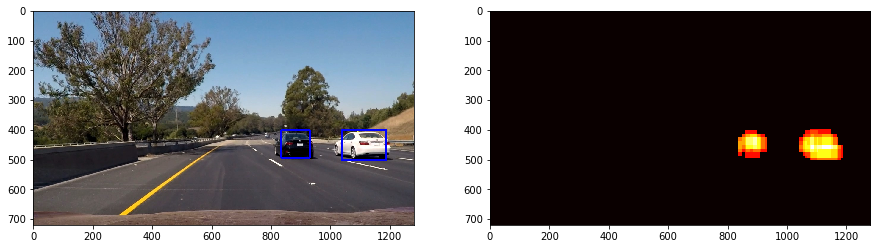

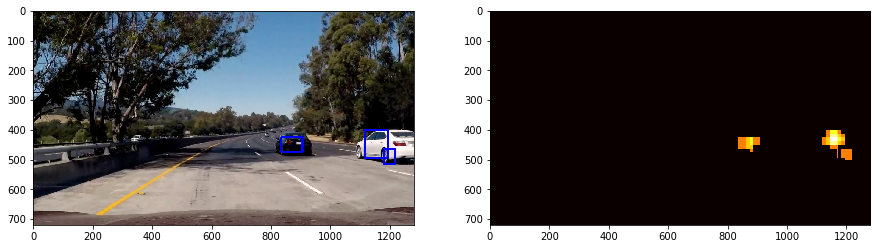

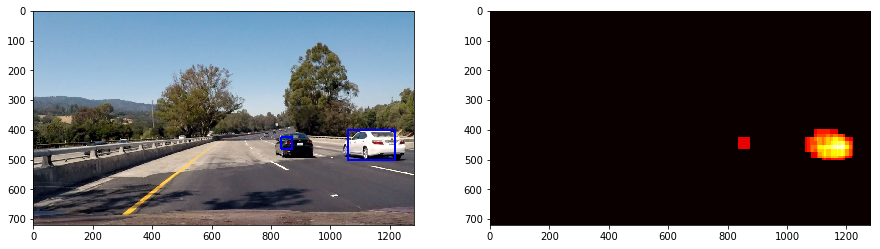

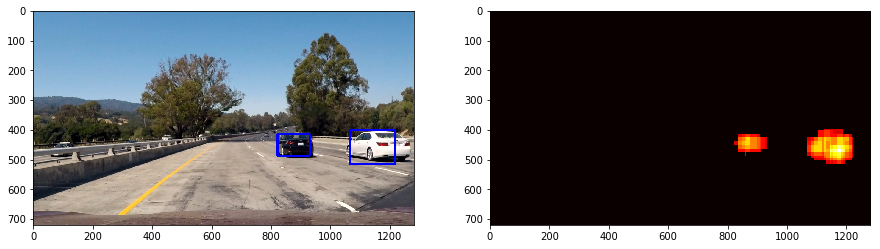

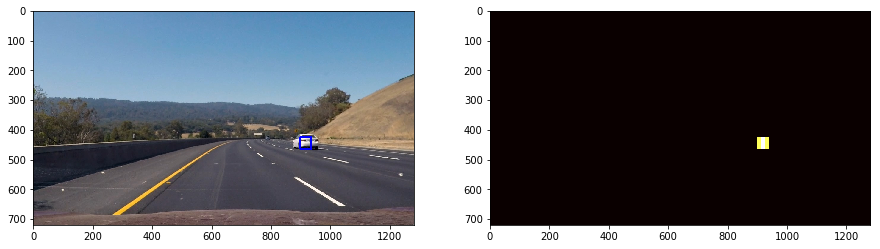

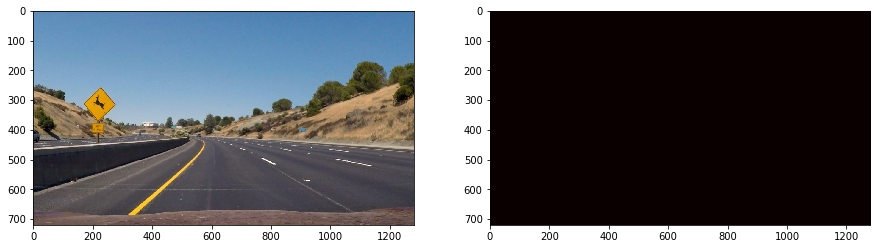

In [95]:
# Test classifier, search regions and heatmap with images provided

t=time.time() 
for testImage in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(testImage)
    draw_image = np.copy(image)
    boxes = find_cars(draw_image, 350, 650, 450, 1280, 0.8, 2)              # General search windows - all area
    boxes += find_cars(draw_image, 400, 650, 450, 1280, 1.5, 2)           # Closer area with larger scale factor
    boxes += find_cars(draw_image, 400, 650, 450, 1280, 2, 2)             # Even closer
    boxes += find_cars(draw_image, 400, 650, 450, 1280, 2.5, 2)           # Closest with largest scaling factor 
    
    # Heatmap
    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)              # Create base heat map image - all black initially 
    heat = add_heat(heat, boxes)
    heat = apply_threshold(heat,thresholdNum)
    heatmap = np.clip(heat, 0, 255)                                  # Visualize the heatmap when displaying

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes_single(np.copy(image), labels)
    print(labels[1], 'cars found in', testImage)
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')

print(round(time.time()-t, 2), 'Seconds to process test images')
print("Estimated Video Processing Time: ", round(((time.time()-t)* 210/60), 2 ), "min" )
    

In [96]:
# Video processing for Car detection and tracking

# Reinitialize parameters
includFrame = True                                           
boxesLast= []

def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(processFrame(image), cv2.COLOR_BGR2RGB)

output_v = 'project_video_proc_wTrack.mp4'
clipIn = VideoFileClip("project_video.mp4")
clipOut = clipIn.fl_image(process_image)
%time clipOut.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video project_video_proc_wTrack.mp4
[MoviePy] Writing video project_video_proc_wTrack.mp4


100%|█████████▉| 1260/1261 [05:03<00:00,  5.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc_wTrack.mp4 

CPU times: user 4min 23s, sys: 18.2 s, total: 4min 41s
Wall time: 5min 4s
